In [86]:
import glob
from itertools import product

from collections import OrderedDict
from matplotlib import gridspec, pylab
import matplotlib.pyplot as plt
import numpy as np
import PIL
from sklearn.manifold import TSNE
from scipy.ndimage import imread
from scipy.misc import imresize, imsave
from scipy.stats import zscore

%matplotlib inline

# Import flag bitmaps as numpy arrays

In [4]:
def extract_country_slug(file):
    return file.split('/')[-1].split('.')[0]

In [5]:
flag_bitmaps = []
countries = []

for file in glob.glob('flags/*.jpg'):
    flag_bitmaps.append( imread(file) )
    countries.append( extract_country_slug(file) )

# Normalize data

## Resize all flags to the proportions of the largest bounding box

In [6]:
flag_bitmap_shapes = [bitmap.shape for bitmap in flag_bitmaps]

max_first_dimension = max([shape[0] for shape in flag_bitmap_shapes])
max_second_dimension = max([shape[1] for shape in flag_bitmap_shapes])
max_third_dimension = max([shape[2] for shape in flag_bitmap_shapes])

max_bounding_box = (max_first_dimension, max_second_dimension, max_third_dimension)
print('Max bounding box: ({}, {}, {})'.format(*max_bounding_box))

Max bounding box: (684, 1025, 3)


In [7]:
reduced_max_bounding_box = (68, 102, 3)
print('Reduced size bounding box ({}, {}, {})'.format(*reduced_max_bounding_box))

Reduced size bounding box (68, 102, 3)


In [8]:
resized_flag_bitmaps = [imresize(bitmap, size=reduced_max_bounding_box) for bitmap in flag_bitmaps]

## Visualize first flag

In [12]:
def visualize_image(image_vector):
    return PIL.Image.fromarray(image_vector)

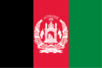

In [13]:
visualize_image(resized_flag_bitmaps[0])

## Scale images to [0, 1], flatten images, then create an input matrix

In [14]:
input_matrix = np.array([bitmap.flatten() / 255. for bitmap in resized_flag_bitmaps])

# Instantiate network

In [15]:
from vanilla_neural_nets.autoencoder.sparse_autoencoder.network import VanillaSparseAutoencoder
from vanilla_neural_nets.neural_network.training_batch_generator import MiniBatchGenerator
from vanilla_neural_nets.autoencoder.sparse_autoencoder.optimization_algorithm import SparsityEnforcingGradientDescent
from vanilla_neural_nets.autoencoder.sparse_autoencoder.loss_function import SparseMeanSquaredError, KLDivergenceSparsityLoss
from vanilla_neural_nets.neural_network.activation_function import SigmoidActivationFunction
from vanilla_neural_nets.neural_network.parameter_initialization import GaussianWeightInitializer, GaussianBiasInitializer

In [16]:
N_HIDDEN_UNITS = 64
N_SAMPLES = input_matrix.shape[0]
N_FEATURES = input_matrix.shape[1]
LAYER_SIZES = [N_FEATURES, N_HIDDEN_UNITS, N_FEATURES]

In [17]:
LEARNING_RATE = .05
TRAINING_BATCH_SIZE = 72
N_EPOCHS = 1000
RANDOM_STATE = 123
RHO = .25
BETA = .25
GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION = 1. / np.sqrt(N_FEATURES)

In [18]:
training_set = input_matrix[:100, :]
validation_set = input_matrix[100:120, :]
test_set = input_matrix[120:, :]

In [20]:
class VanillaSparseAutoencoderWithLogging(VanillaSparseAutoencoder):
    
    def fit(self, X, y):
        for epoch in range(self.n_epochs):
            training_batch_generator = self.training_batch_generator_class(X=X, y=y, batch_size=self.training_batch_size,
                random_number_generator=self.random_number_generator)

            for training_batch in training_batch_generator:
                self.parameters = self._update_network_layers_with_training_batch(training_batch)
                
            if epoch % 100 == 0:
                print('Epoch: {}'.format(epoch))
                print('Training Loss: {}'.format( self._compute_loss(X=X, y=y)) )
                print('Validation Loss: {}'.format( self._compute_loss(X=validation_set, y=validation_set)) )
                print('Test Loss: {}'.format( self._compute_loss(X=test_set, y=test_set)) )
            
    def _compute_loss(self, X, y):
        predictions, mean_hidden_layer_activations = self.predict(X)
        loss = self.loss_function_class.loss(
            y_true=y,
            y_predicted=predictions,
            rho=RHO,
            vector_of_rho_hats=mean_hidden_layer_activations,
            beta=BETA
        )
        if np.isinf(loss).sum() > 0:
            from IPython.core.debugger import Tracer; Tracer()()
        return loss

In [21]:
network = VanillaSparseAutoencoderWithLogging(
    layer_sizes=LAYER_SIZES,
    training_batch_generator_class=MiniBatchGenerator,
    loss_function_class=SparseMeanSquaredError,
    activation_function_class=SigmoidActivationFunction,
    optimization_algorithm_class=SparsityEnforcingGradientDescent,
    sparsity_constraint_class=KLDivergenceSparsityLoss,
    learning_rate=LEARNING_RATE,
    n_epochs=N_EPOCHS,
    training_batch_size=TRAINING_BATCH_SIZE,
    random_state=RANDOM_STATE,
    rho=RHO,
    beta=BETA,
    weight_initializer=GaussianWeightInitializer(
        GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION,
        random_state=RANDOM_STATE
    ),
    bias_initializer=GaussianBiasInitializer(
        GAUSSIAN_INITIALIZATER_STANDARD_DEVIATION,
        random_state=RANDOM_STATE
    )
)

# Train

In [22]:
network.fit(X=training_set, y=training_set)

Epoch: 0
Training Loss: 1492.2036672942002
Validation Loss: 1497.8751382281148
Test Loss: 1481.109061962667
Epoch: 100
Training Loss: 851.6327713041528
Validation Loss: 1103.0073690445663
Test Loss: 1044.3528713297865
Epoch: 200
Training Loss: 671.9929371738477
Validation Loss: 971.0444204898229
Test Loss: 969.0225455702124
Epoch: 300
Training Loss: 616.2453199656202
Validation Loss: 949.6605806090613
Test Loss: 961.0346556878642
Epoch: 400
Training Loss: 542.749042886094
Validation Loss: 879.8796262140119
Test Loss: 930.4350311184423
Epoch: 500
Training Loss: 497.56546668135155
Validation Loss: 857.1482580430469
Test Loss: 909.7298397679211
Epoch: 600
Training Loss: 477.2504010511342
Validation Loss: 841.6534417684651
Test Loss: 917.7644770734671
Epoch: 700
Training Loss: 460.03008463426795
Validation Loss: 843.366745998657
Test Loss: 915.1888259542319
Epoch: 800
Training Loss: 436.4245940867076
Validation Loss: 827.5602451990983
Test Loss: 914.458007715499
Epoch: 900
Training Loss: 4

/Users/willwolf/Documents/willwolf/vanilla-neural-nets/vanilla_neural_nets/neural_network/activation_function.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-linear_combination))


# Visualize features

In [23]:
def reshape_for_visualization(image_vector):
    return (image_vector.reshape(*reduced_max_bounding_box) * 255).astype(np.uint8)

In [24]:
maximally_activating_inputs = []

for row in network.parameters.weight_parameters[0].value:
    norm_bounded_input = row / np.linalg.norm(row)
    maximally_activating_inputs.append( reshape_for_visualization(norm_bounded_input) )

In [ ]:
plt.savefig('figures/features.png', bbo)

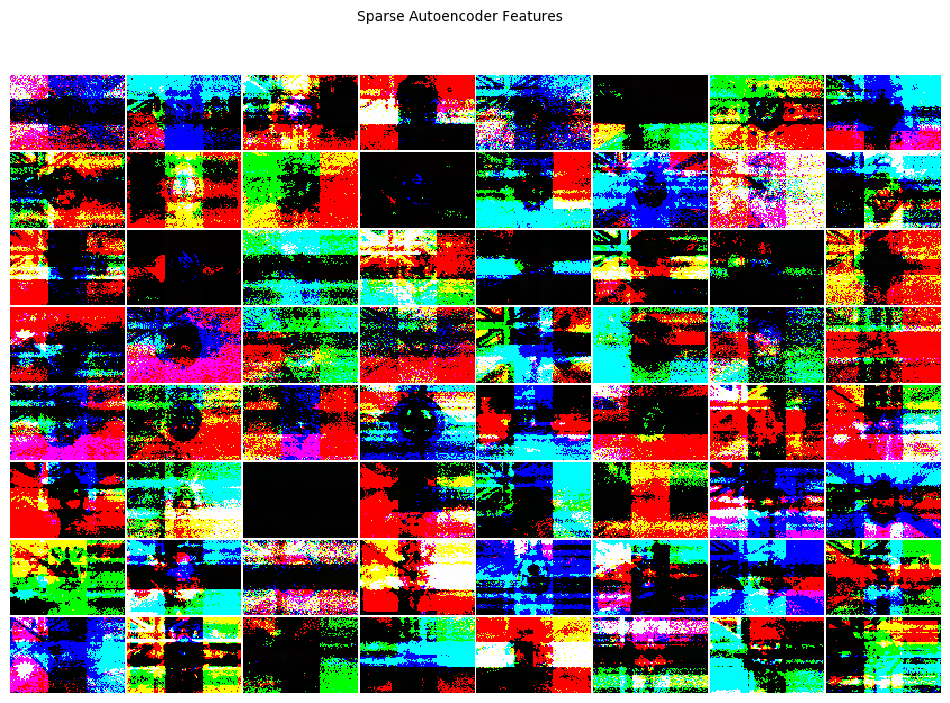

In [58]:
n_rows = n_cols = 8

plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=.025, hspace=0)

for i, (r, c) in enumerate(product(range(n_rows), range(n_cols))):
    ax = plt.subplot(gs[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.imshow(maximally_activating_inputs[i], cmap='gray', interpolation='nearest')

plt.suptitle('Sparse Autoencoder Features')
plt.savefig('figures/features.png')

# How well can the autoencoder recreate an image?

In [26]:
afghanistan_input = input_matrix[0]
afghanistan_reduced_bitmap = reshape_for_visualization(afghanistan_input)

## Original, reduced-size Afghanistan flag

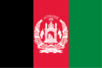

In [27]:
visualize_image(afghanistan_reduced_bitmap)

In [103]:
imsave('figures/afghanistan_reduced_bitmap.png', afghanistan_reduced_bitmap)

## Reduced-sized Afghanistan flag reconstructed by our network

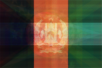

In [28]:
prediction, hidden_layer_activations = network.predict(afghanistan_input)
reconstructed_afghanistan_reduced_bitmap = reshape_for_visualization(prediction)

visualize_image(reconstructed_afghanistan_reduced_bitmap)

In [104]:
imsave('figures/reconstructed_afghanistan_reduced_bitmap.png', reconstructed_afghanistan_reduced_bitmap)

# How do the upscaled bitmaps look?

## Reduced-size Afghanistan bitmap, upscaled back to original dimensions

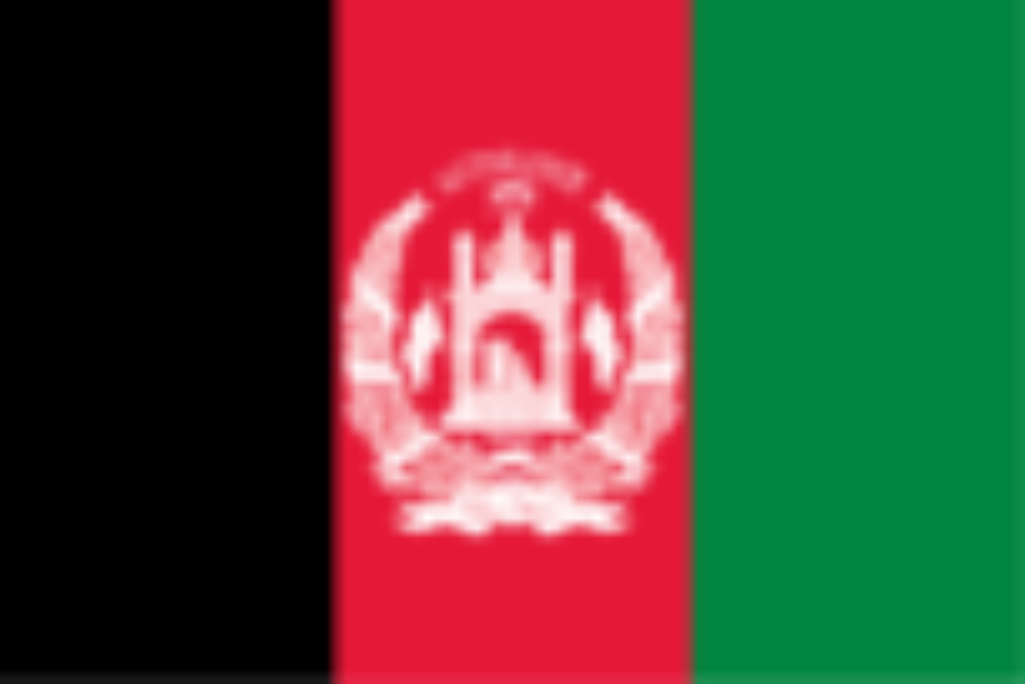

In [29]:
upscaled_afghanistan_reduced_bitmap = imresize(afghanistan_reduced_bitmap, size=max_bounding_box)
visualize_image(upscaled_afghanistan_reduced_bitmap)

## Reduced-size *reconstructed* Afghanistan bitmap, upscaled back to original dimensions

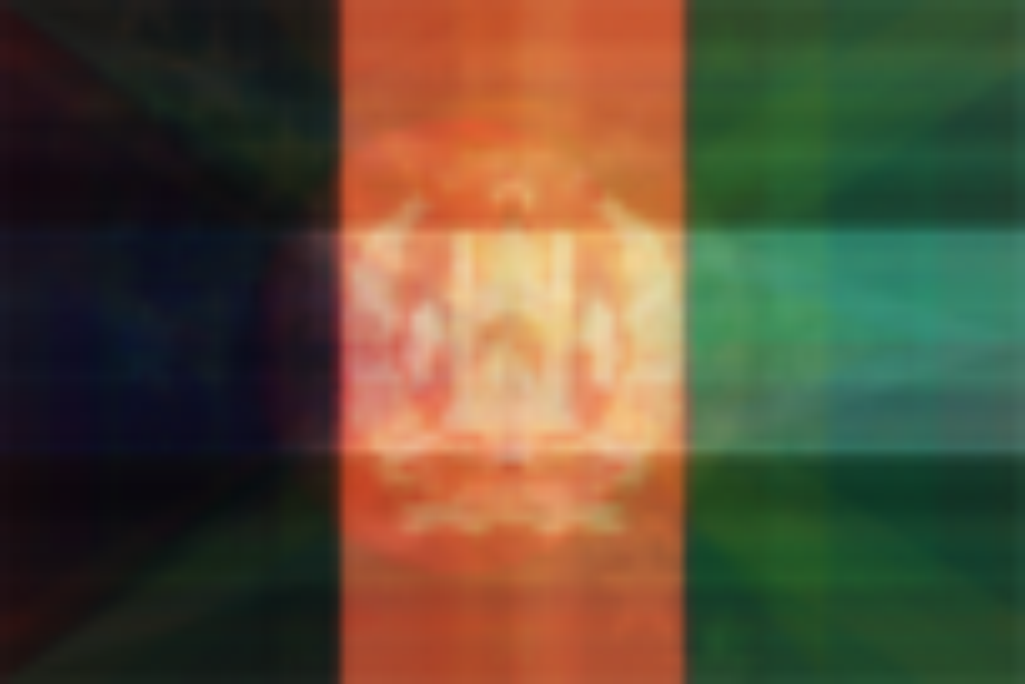

In [30]:
upscaled_reconstructed_afghanistan_reduced_bitmap = imresize(reconstructed_afghanistan_reduced_bitmap, size=max_bounding_box)
visualize_image(upscaled_reconstructed_afghanistan_reduced_bitmap)

# Which flags have similar features?

## Retrieve encodings for each country

In [40]:
encodings = OrderedDict()
for country, country_input in zip(countries, input_matrix):
    _, encoding = network.predict( country_input.reshape(1, -1) )
    encodings[country] = encoding
    
encodings_matrix = np.array( list(encodings.values()) )

/Users/willwolf/Documents/willwolf/vanilla-neural-nets/vanilla_neural_nets/neural_network/activation_function.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-linear_combination))


## Plot in 2-dimensional TSNE space

In [82]:
def plot_two_dimensional_vectors(encodings, countries):

    pylab.figure(figsize=(15,15))

    for index, country in enumerate(countries):
        x, y = encodings[index, :]
        pylab.scatter(x, y)
        pylab.annotate(country, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')

    pylab.savefig('figures/tsne_plot.png')
    pylab.show()

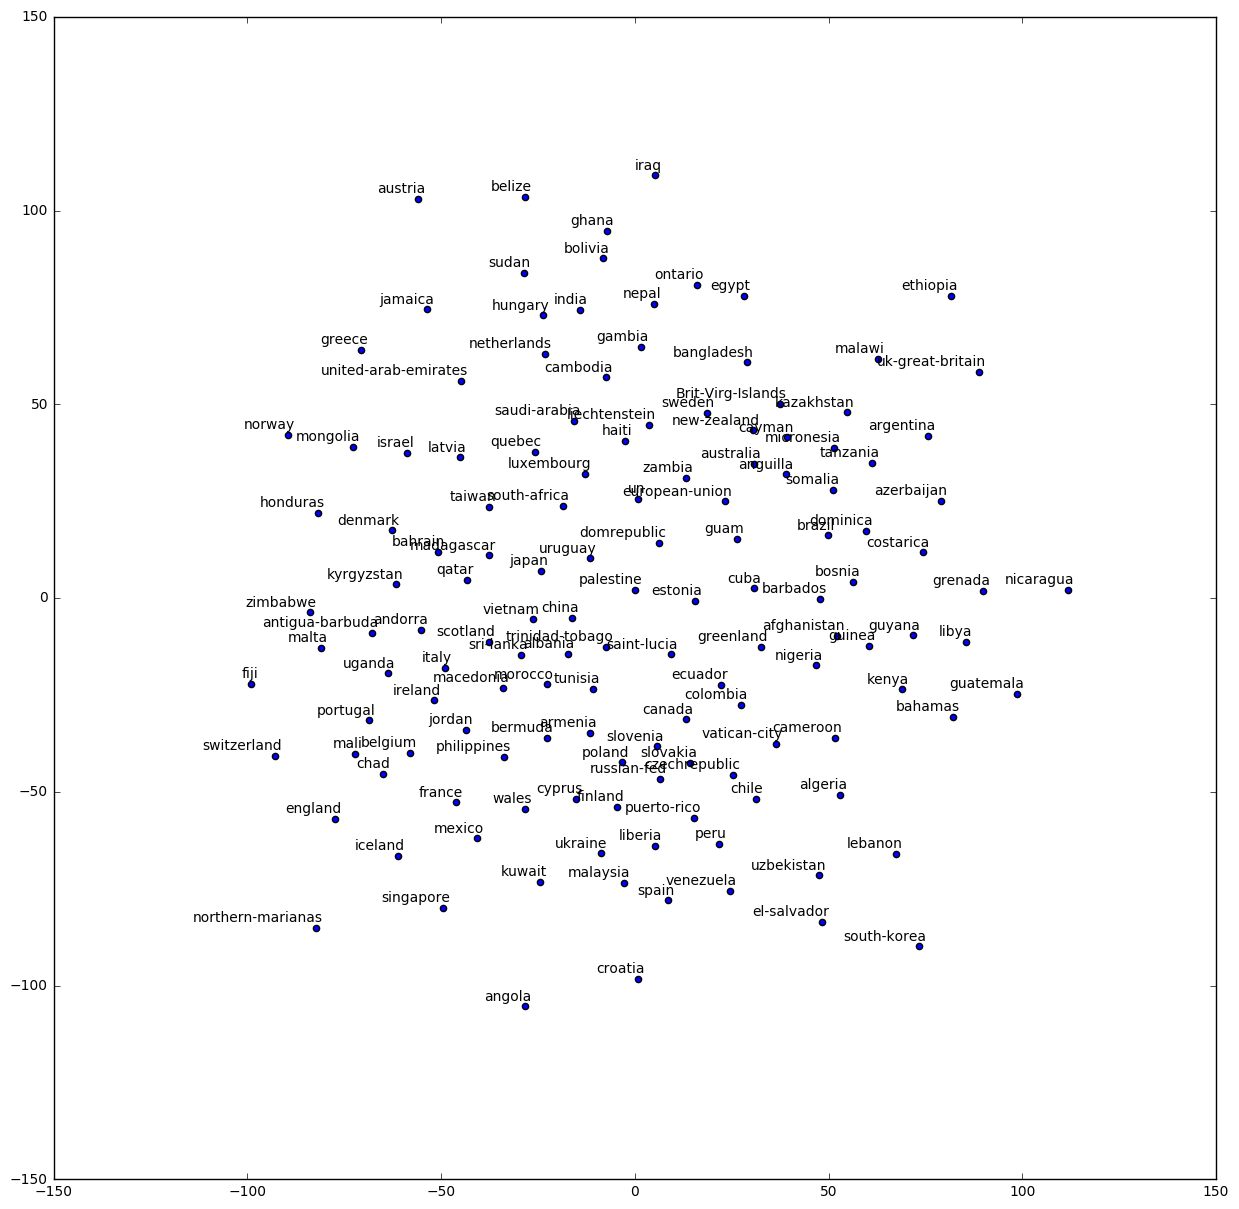

In [83]:
two_dimensional_tsne_encodings = TSNE(n_components=2).fit_transform(encodings_matrix)

plot_two_dimensional_vectors(two_dimensional_tsne_encodings, countries)

# Generate new flags

## Morocco

In [84]:
composite_prediction = network.generate(encodings['morocco'])

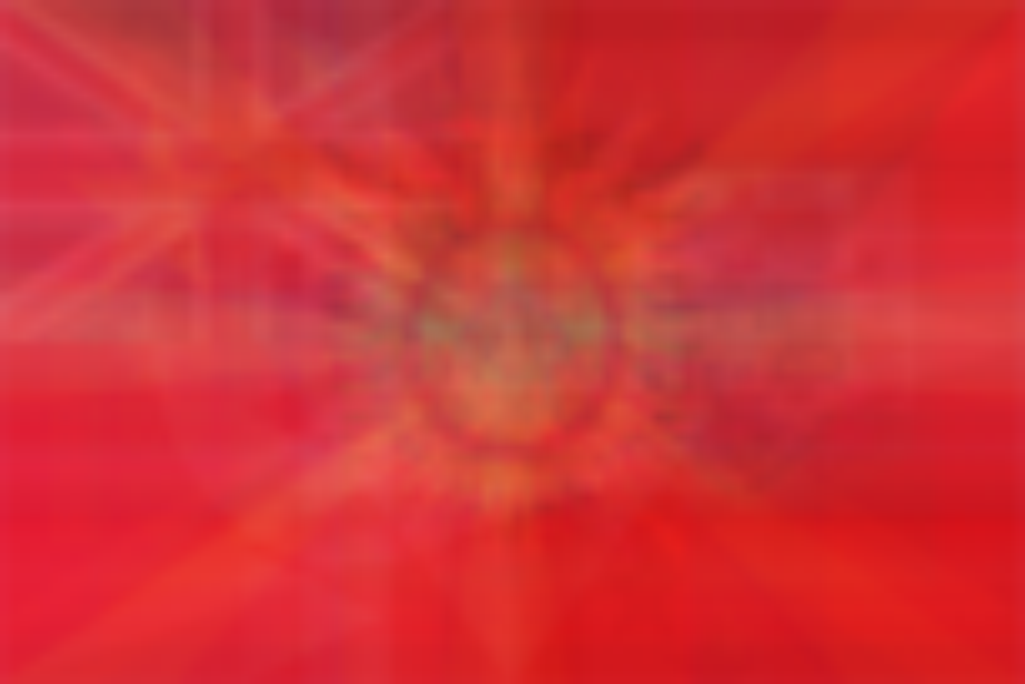

In [89]:
composite_prediction_reshaped = reshape_for_visualization(composite_prediction)
upscaled_composite_prediction_reshaped = imresize(composite_prediction_reshaped, size=max_bounding_box)

visualize_image(upscaled_composite_prediction_reshaped)

In [90]:
imsave('figures/morocco.png', upscaled_composite_prediction_reshaped)

## Morocco + Colombia

In [92]:
composite_prediction = network.generate(encodings['morocco'] + encodings['colombia'])

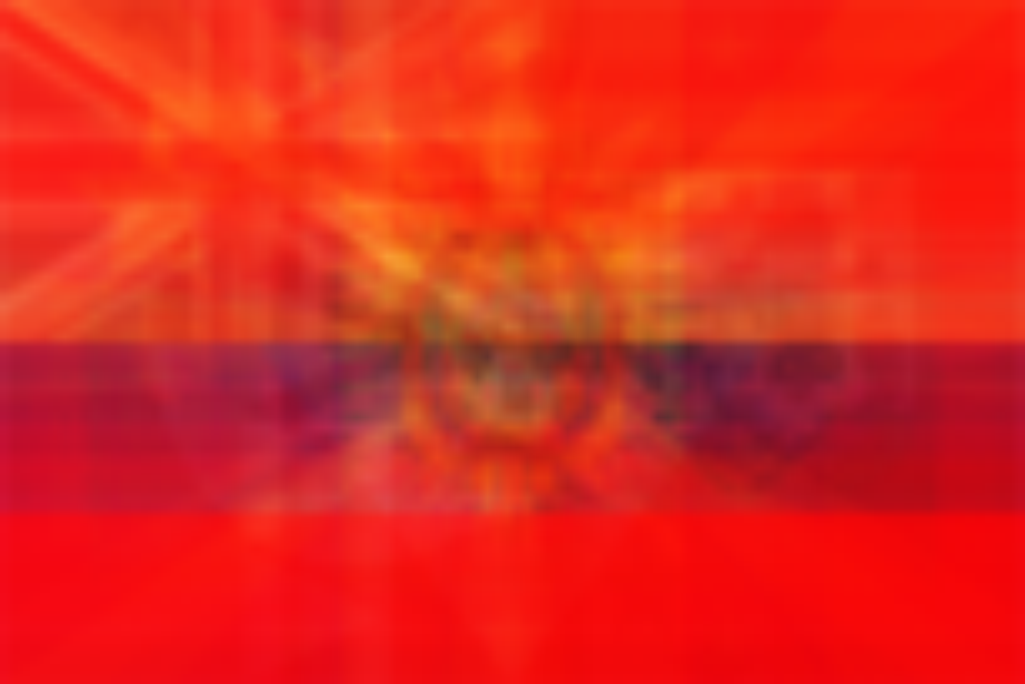

In [93]:
composite_prediction_reshaped = reshape_for_visualization(composite_prediction)
upscaled_composite_prediction_reshaped = imresize(composite_prediction_reshaped, size=max_bounding_box)

visualize_image(upscaled_composite_prediction_reshaped)

In [95]:
imsave('figures/morocco_colombia.png', upscaled_composite_prediction_reshaped)

## Morocco + Colombia + Malaysia

In [96]:
composite_prediction = network.generate(
    encodings['morocco'] + \
    encodings['colombia'] + \
    encodings['malaysia']
)

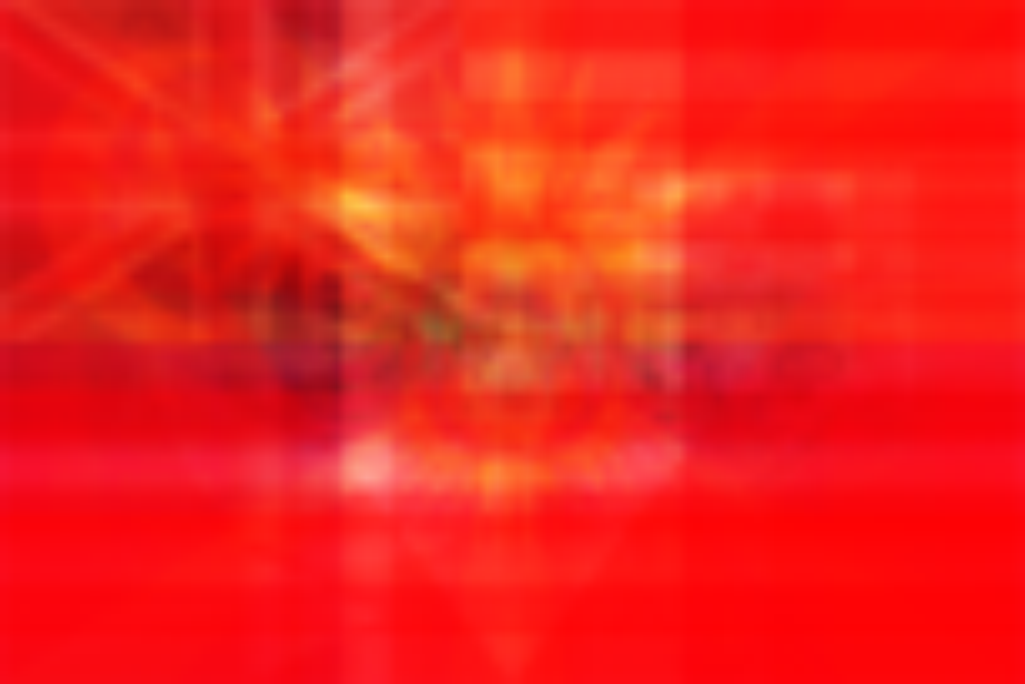

In [97]:
composite_prediction_reshaped = reshape_for_visualization(composite_prediction)
upscaled_composite_prediction_reshaped = imresize(composite_prediction_reshaped, size=max_bounding_box)

visualize_image(upscaled_composite_prediction_reshaped)

In [99]:
imsave('figures/morocco_colombia_malaysia.png', upscaled_composite_prediction_reshaped)